# Sentiment prediction 

In [28]:
# importing the libraries

import tensorflow as tf
import tensorflow_datasets as tfds

import numpy as np

# Get the dataset


In [29]:
# Get the dataset.

dataset, info = tfds.load('glue/sst2', with_info=True)
print(info.features)
print(info.features["label"].num_classes)
print(info.features["label"].names)


FeaturesDict({
    'idx': tf.int32,
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    'sentence': Text(shape=(), dtype=tf.string),
})
2
['negative', 'positive']


In [30]:
# Get the training and validation datasets

dataset_train, dataset_validation = dataset['train'], dataset['validation']
dataset_train

<DatasetV1Adapter shapes: {idx: (), label: (), sentence: ()}, types: {idx: tf.int32, label: tf.int64, sentence: tf.string}>

In [31]:
# Print some of the entries

for example in dataset_train.take(2):  
  review, label = example["sentence"], example["label"]
  print("Review:", review)
  print("Label: %d \n" % label.numpy())

Review: tf.Tensor(b'for the uninitiated plays better on video with the sound ', shape=(), dtype=string)
Label: 0 

Review: tf.Tensor(b'like a giant commercial for universal studios , where much of the action takes place ', shape=(), dtype=string)
Label: 0 



In [32]:
# Get the sentences and the labels
# for both the training and the validation sets

training_reviews = []
training_labels = []
 
validation_reviews = []
validation_labels = []

# Get training data

for item in dataset_train.take(-1):
  review, label = item["sentence"], item["label"]
  training_reviews.append(str(review.numpy()))
  training_labels.append(label.numpy())

print ("\nNumber of training reviews is: ", len(training_reviews))

# print some of the reviews and labels
for i in range(0, 2):
  print (training_reviews[i])
  print (training_labels[i])

# Get the validation data

for item in dataset_validation.take(-1):  
  review, label = item["sentence"], item["label"]
  validation_reviews.append(str(review.numpy()))
  validation_labels.append(label.numpy())

print ("\nNumber of validation reviews is: ", len(validation_reviews))

# Print some of the validation reviews and labels
for i in range(0, 2):
  print (validation_reviews[i])
  print (validation_labels[i])



Number of training reviews is:  67349
b'for the uninitiated plays better on video with the sound '
0
b'like a giant commercial for universal studios , where much of the action takes place '
0

Number of validation reviews is:  872
b'a valueless kiddie paean to pro basketball underwritten by the nba . '
0
b"featuring a dangerously seductive performance from the great daniel auteuil , `` sade '' covers the same period as kaufmann 's `` quills '' with more unsettlingly realistic results . "
1


# Tokenize the words and sequence the sentences


In [33]:
# Tokenization and sequencing the sentences 

vocab_size = 4000
embedding_dim = 16
max_length = 50
trunc_type='post'
pad_type='post'
oov_tok = "<OOV>"

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_reviews)
word_index = tokenizer.word_index


# Pad the sequences

In [34]:
# Pad the sequences so that they are all the same length

# padding trainig data
training_sequences = tokenizer.texts_to_sequences(training_reviews)
training_padded = pad_sequences(training_sequences,maxlen=max_length, 
                                truncating=trunc_type, padding=pad_type)

# padding validation data
validation_sequences = tokenizer.texts_to_sequences(validation_reviews)
validation_padded = pad_sequences(validation_sequences,maxlen=max_length)

# converting them to a numpy array 
training_labels_final = np.array(training_labels)
validation_labels_final = np.array(validation_labels)

# Create the model using an Embedding

In [35]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),  
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 50, 16)            64000     
_________________________________________________________________
global_average_pooling1d_1 ( (None, 16)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 17        
Total params: 64,017
Trainable params: 64,017
Non-trainable params: 0
_________________________________________________________________


# Train the model

In [36]:
num_epochs = 20
history = model.fit(training_padded, training_labels_final, epochs=num_epochs, 
                    validation_data=(validation_padded, validation_labels_final))


Epoch 1/20
2105/2105 [==============================] - 7s 3ms/step - loss: 0.6368 - accuracy: 0.6300 - val_loss: 0.5403 - val_accuracy: 0.7385
Epoch 2/20
2105/2105 [==============================] - 7s 3ms/step - loss: 0.4960 - accuracy: 0.7735 - val_loss: 0.4548 - val_accuracy: 0.8016
Epoch 3/20
2105/2105 [==============================] - 7s 3ms/step - loss: 0.4147 - accuracy: 0.8141 - val_loss: 0.4542 - val_accuracy: 0.8050
Epoch 4/20
2105/2105 [==============================] - 7s 3ms/step - loss: 0.3738 - accuracy: 0.8289 - val_loss: 0.4695 - val_accuracy: 0.8005
Epoch 5/20
2105/2105 [==============================] - 7s 3ms/step - loss: 0.3513 - accuracy: 0.8367 - val_loss: 0.4991 - val_accuracy: 0.7970
Epoch 6/20
2105/2105 [==============================] - 7s 3ms/step - loss: 0.3374 - accuracy: 0.8414 - val_loss: 0.5231 - val_accuracy: 0.7947
Epoch 7/20
2105/2105 [==============================] - 7s 3ms/step - loss: 0.3287 - accuracy: 0.8433 - val_loss: 0.5424 - val_accuracy:

# Plot the accurracy and loss

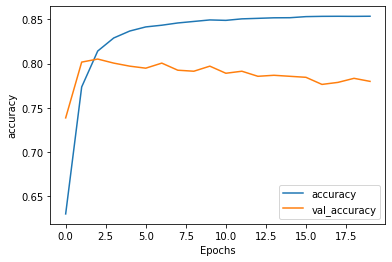

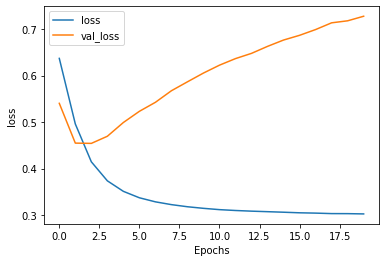

In [37]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

# Write a function to predict the sentiment of reviews

In [38]:
# Write some new reviews 

review1 = """I loved the other movie more than this"""

review2 = """that was the best movie I've ever seen"""

review3 = """too much of nonsense even for a comedy film"""

review4 = """too emotional for an action movie"""

new_reviews = [review1, review2, review3, review4]


In [39]:
# Define a function to prepare the new reviews for use with a model
# and then use the model to predict the sentiment of the new reviews           

def predict_review(model, reviews):
  
  padding_type='post'
  sample_sequences = tokenizer.texts_to_sequences(reviews)
  reviews_padded = pad_sequences(sample_sequences, padding=padding_type, 
                                 maxlen=max_length) 
  classes = model.predict(reviews_padded)
  for x in range(len(reviews_padded)):
    print(reviews[x])
    print(classes[x])
    print('\n')

predict_review(model, new_reviews)


I loved the other movie more than this
[0.89170784]


that was the best movie I've ever seen
[0.9148315]


too much of nonsense even for a comedy film
[0.04570353]


too emotional for an action movie
[0.09362598]




# Define a function to train and show the results of models with different layers

In [40]:
def fit_model_and_show_results (model, reviews):
  model.summary()
  history = model.fit(training_padded, training_labels_final, epochs=num_epochs, 
                      validation_data=(validation_padded, validation_labels_final))
  plot_graphs(history, "accuracy")
  plot_graphs(history, "loss")
  predict_review(model, reviews)

# Use a CNN

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 50, 16)            64000     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 46, 16)            1296      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 16)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 17        
Total params: 65,313
Trainable params: 65,313
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
2105/2105 [==============================] - 8s 4ms/step - loss: 0.6752 - accuracy: 0.5723 - val_loss: 0.6650 - val_accuracy: 0.6858
Epoch 2/30
2105/2105 [==============================] - 8s 4ms/step - loss: 0.5797 - accuracy: 0.7242 - 

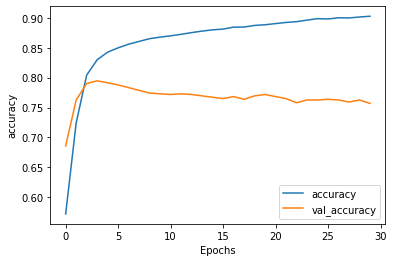

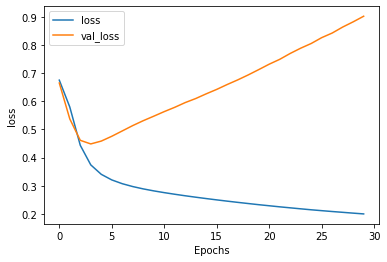

I loved the other movie more than this
[0.93728733]


that was the best movie I've ever seen
[0.96665144]


too much of nonsense even for a comedy film
[0.11486857]


too emotional for an action movie
[0.08074392]




In [41]:
num_epochs = 30

model_cnn = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Conv1D(16, 5, activation='relu'),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Default learning rate for the Adam optimizer is 0.001
# Let's slow down the learning rate by 10.
learning_rate = 0.0001
model_cnn.compile(loss='binary_crossentropy',
                  optimizer=tf.keras.optimizers.Adam(learning_rate), 
                  metrics=['accuracy'])

fit_model_and_show_results(model_cnn, new_reviews)

# Use a GRU

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 50, 16)            64000     
_________________________________________________________________
bidirectional_4 (Bidirection (None, 64)                9600      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 65        
Total params: 73,665
Trainable params: 73,665
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
2105/2105 [==============================] - 18s 9ms/step - loss: 0.6850 - accuracy: 0.5578 - val_loss: 0.6974 - val_accuracy: 0.5092
Epoch 2/30
2105/2105 [==============================] - 18s 8ms/step - loss: 0.6401 - accuracy: 0.6099 - val_loss: 0.6113 - val_accuracy: 0.6307
Epoch 3/30
2105/2105 [==============================] - 18s 8ms/step - loss: 0.5491 - accu

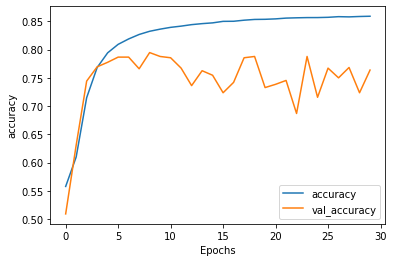

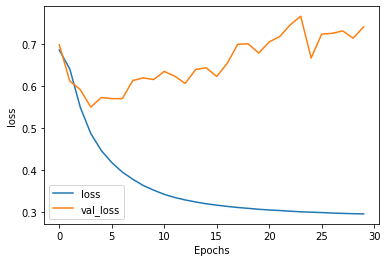

I loved the other movie more than this
[0.80576974]


that was the best movie I've ever seen
[0.6893645]


too much of nonsense even for a comedy film
[0.05011868]


too emotional for an action movie
[0.07825635]




In [42]:
num_epochs = 30

model_gru = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

learning_rate = 0.00003 # slower than the default learning rate
model_gru.compile(loss='binary_crossentropy',
                  optimizer=tf.keras.optimizers.Adam(learning_rate),
                  metrics=['accuracy'])

fit_model_and_show_results(model_gru, new_reviews)

# Add a bidirectional LSTM

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 50, 16)            64000     
_________________________________________________________________
bidirectional_5 (Bidirection (None, 32)                4224      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 33        
Total params: 68,257
Trainable params: 68,257
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
2105/2105 [==============================] - 19s 9ms/step - loss: 0.6835 - accuracy: 0.5578 - val_loss: 0.7018 - val_accuracy: 0.5092
Epoch 2/30
2105/2105 [==============================] - 18s 9ms/step - loss: 0.6657 - accuracy: 0.5826 - val_loss: 0.7125 - val_accuracy: 0.5092
Epoch 3/30
2105/2105 [==============================] - 18s 9ms/step - loss: 0.6223 - accu

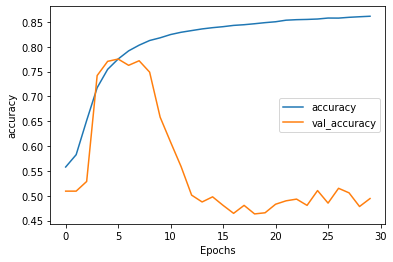

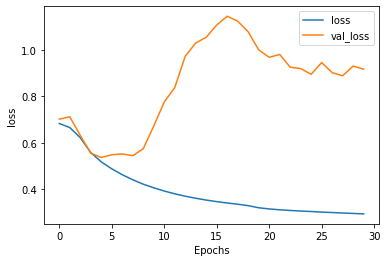

I loved the other movie more than this
[0.81208456]


that was the best movie I've ever seen
[0.7652248]


too much of nonsense even for a comedy film
[0.06981885]


too emotional for an action movie
[0.06628259]




In [43]:
num_epochs = 30

model_bidi_lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)), 
    tf.keras.layers.Dense(1, activation='sigmoid')
])

learning_rate = 0.00003
model_bidi_lstm.compile(loss='binary_crossentropy',
                        optimizer=tf.keras.optimizers.Adam(learning_rate),
                        metrics=['accuracy'])
fit_model_and_show_results(model_bidi_lstm, new_reviews)

# Use multiple bidirectional LSTMs

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 50, 16)            64000     
_________________________________________________________________
bidirectional_6 (Bidirection (None, 50, 32)            4224      
_________________________________________________________________
bidirectional_7 (Bidirection (None, 32)                6272      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 33        
Total params: 74,529
Trainable params: 74,529
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
2105/2105 [==============================] - 31s 15ms/step - loss: 0.4665 - accuracy: 0.7560 - val_loss: 0.8146 - val_accuracy: 0.5264
Epoch 2/30
2105/2105 [==============================] - 29s 14ms/step - loss: 0.3456 - accuracy: 0.836

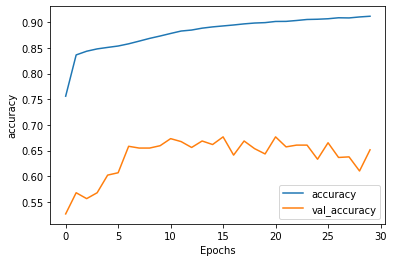

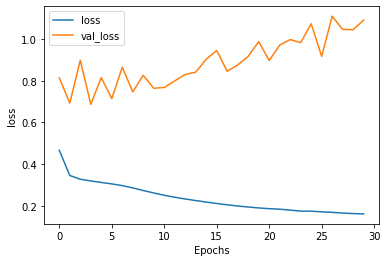

I loved the other movie more than this
[0.9913874]


that was the best movie I've ever seen
[0.98994267]


too much of nonsense even for a comedy film
[0.00017585]


too emotional for an action movie
[0.00998489]




In [44]:
num_epochs = 30

model_multiple_bidi_lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim, 
                                                       return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

learning_rate = 0.0003
model_multiple_bidi_lstm.compile(loss='binary_crossentropy',
                                 optimizer=tf.keras.optimizers.Adam(learning_rate),
                                 metrics=['accuracy'])
fit_model_and_show_results(model_multiple_bidi_lstm, new_reviews)

# Try some more reviews

In [45]:
# Write some new reviews 

review1 = """I loved this movie"""

review2 = """that was the worst movie I've ever seen"""

review3 = """too much violence even for a Bond film"""

review4 = """a captivating recounting of a cherished myth"""

review5 = """I saw this movie yesterday and I was feeling low to start with,
 but it was such a wonderful movie that it lifted my spirits and brightened 
 my day, you can\'t go wrong with a movie with Whoopi Goldberg in it."""

review6 = """I don\'t understand why it received an oscar recommendation
 for best movie, it was long and boring"""

review7 = """the scenery was magnificent, the CGI of the dogs was so realistic I
 thought they were played by real dogs even though they talked!"""

review8 = """The ending was so sad and yet so uplifting at the same time. 
 I'm looking for an excuse to see it again"""

review9 = """I had expected so much more from a movie made by the director 
 who made my most favorite movie ever, I was very disappointed in the tedious 
 story"""

review10 = "I wish I could watch this movie every day for the rest of my life"

more_reviews = [review1, review2, review3, review4, review5, review6, review7, 
               review8, review9, review10]


In [46]:
print("============================\n","Embeddings only:\n", "============================")
predict_review(model, more_reviews)

 Embeddings only:
I loved this movie
[0.93564194]


that was the worst movie I've ever seen
[0.00482019]


too much violence even for a Bond film
[0.04130644]


a captivating recounting of a cherished myth
[0.9147912]


I saw this movie yesterday and I was feeling low to start with,
 but it was such a wonderful movie that it lifted my spirits and brightened 
 my day, you can't go wrong with a movie with Whoopi Goldberg in it.
[0.9599217]


I don't understand why it received an oscar recommendation
 for best movie, it was long and boring
[0.9946009]


the scenery was magnificent, the CGI of the dogs was so realistic I
 thought they were played by real dogs even though they talked!
[0.41208076]


The ending was so sad and yet so uplifting at the same time. 
 I'm looking for an excuse to see it again
[0.6280444]


I had expected so much more from a movie made by the director 
 who made my most favorite movie ever, I was very disappointed in the tedious 
 story
[0.00012474]


I wish I coul

In [47]:
print("============================\n","With CNN\n", "============================")
predict_review(model_cnn, more_reviews)

 With CNN
I loved this movie
[0.9984994]


that was the worst movie I've ever seen
[0.00013882]


too much violence even for a Bond film
[0.05010544]


a captivating recounting of a cherished myth
[0.9403805]


I saw this movie yesterday and I was feeling low to start with,
 but it was such a wonderful movie that it lifted my spirits and brightened 
 my day, you can't go wrong with a movie with Whoopi Goldberg in it.
[0.90748924]


I don't understand why it received an oscar recommendation
 for best movie, it was long and boring
[0.99995387]


the scenery was magnificent, the CGI of the dogs was so realistic I
 thought they were played by real dogs even though they talked!
[0.879283]


The ending was so sad and yet so uplifting at the same time. 
 I'm looking for an excuse to see it again
[0.9999536]


I had expected so much more from a movie made by the director 
 who made my most favorite movie ever, I was very disappointed in the tedious 
 story
[0.01187014]


I wish I could watch t

In [48]:
print("===========================\n","With bidirectional GRU\n", "============================")
predict_review(model_gru, more_reviews)

 With bidirectional GRU
I loved this movie
[0.91332126]


that was the worst movie I've ever seen
[0.00475106]


too much violence even for a Bond film
[0.03120645]


a captivating recounting of a cherished myth
[0.76523906]


I saw this movie yesterday and I was feeling low to start with,
 but it was such a wonderful movie that it lifted my spirits and brightened 
 my day, you can't go wrong with a movie with Whoopi Goldberg in it.
[0.9784032]


I don't understand why it received an oscar recommendation
 for best movie, it was long and boring
[0.68355095]


the scenery was magnificent, the CGI of the dogs was so realistic I
 thought they were played by real dogs even though they talked!
[0.05760221]


The ending was so sad and yet so uplifting at the same time. 
 I'm looking for an excuse to see it again
[0.10081544]


I had expected so much more from a movie made by the director 
 who made my most favorite movie ever, I was very disappointed in the tedious 
 story
[0.08193413]


I wi

In [49]:
print("===========================\n", "With a single bidirectional LSTM:\n", "===========================")
predict_review(model_bidi_lstm, more_reviews)

 With a single bidirectional LSTM:
I loved this movie
[0.94778234]


that was the worst movie I've ever seen
[0.01649025]


too much violence even for a Bond film
[0.06360678]


a captivating recounting of a cherished myth
[0.73745865]


I saw this movie yesterday and I was feeling low to start with,
 but it was such a wonderful movie that it lifted my spirits and brightened 
 my day, you can't go wrong with a movie with Whoopi Goldberg in it.
[0.97388726]


I don't understand why it received an oscar recommendation
 for best movie, it was long and boring
[0.48348778]


the scenery was magnificent, the CGI of the dogs was so realistic I
 thought they were played by real dogs even though they talked!
[0.07408796]


The ending was so sad and yet so uplifting at the same time. 
 I'm looking for an excuse to see it again
[0.3122338]


I had expected so much more from a movie made by the director 
 who made my most favorite movie ever, I was very disappointed in the tedious 
 story
[0.05828

In [50]:
print("===========================\n", "With multiple bidirectional LSTM:\n", "==========================")
predict_review(model_multiple_bidi_lstm, more_reviews)

 With multiple bidirectional LSTM:
I loved this movie
[0.9970585]


that was the worst movie I've ever seen
[0.0005719]


too much violence even for a Bond film
[0.00023752]


a captivating recounting of a cherished myth
[0.99791425]


I saw this movie yesterday and I was feeling low to start with,
 but it was such a wonderful movie that it lifted my spirits and brightened 
 my day, you can't go wrong with a movie with Whoopi Goldberg in it.
[0.40948093]


I don't understand why it received an oscar recommendation
 for best movie, it was long and boring
[0.99998]


the scenery was magnificent, the CGI of the dogs was so realistic I
 thought they were played by real dogs even though they talked!
[0.01199822]


The ending was so sad and yet so uplifting at the same time. 
 I'm looking for an excuse to see it again
[0.99995816]


I had expected so much more from a movie made by the director 
 who made my most favorite movie ever, I was very disappointed in the tedious 
 story
[0.00116938]